In [56]:
import os
import sys

top_level_path = os.path.realpath('.')

def add_to_path(path):
    if path not in sys.path:
        sys.path.append(path)

add_to_path(top_level_path)

In [57]:
import pickle
import pandas as pd
import re
import numpy as np
import torch

In [3]:
# from research.subtoken.train.train import main

# # 4666 - subtoken
# # 4667 - no subtoken

# slurmid = "4666"
# step = 50000
# bytes_per_token = 16
# with open(f"../../{slurmid}_args.pickle", 'rb') as f:
#     args = pickle.load(f)

# args.load_weights_path = f"../../checkpoints/{slurmid}/{step}.pt"

# model = main(rank=None, args=args, return_model=True)

In [58]:
from research.subtoken.train.train import main


# 4734 / /home/ubuntu/llm-random-group/llm-random-cemetery/subtoken_2024-06-28_22-18-10 no subtoken
# 4731 / /home/ubuntu/llm-random-group/llm-random-cemetery/subtoken_2024-06-28_22-13-58 subtoken
slurmid = "4727"
step = 100_000
# parent_dir = '/home/ubuntu/llm-random-group/llm-random-cemetery/subtoken_2024-06-25_12-11-34'
# parent_dir = '../..'
# parent_dir = '/home/ubuntu/llm-random-group/llm-random-cemetery/subtoken_2024-06-26_11-17-38'
# parent_dir = '/home/ubuntu/llm-random-group/llm-random-cemetery/subtoken_2024-06-28_22-18-10'
parent_dir = '/home/ubuntu/llm-random-group/llm-random-cemetery/subtoken_2024-06-28_22-13-58'


bytes_per_token = 16
with open(f"{parent_dir}/{slurmid}_args.pickle", 'rb') as f:
    args = pickle.load(f)

args.fsdp_enabled=False
args.load_weights_path = f"{parent_dir}/checkpoints/{slurmid}/{step}.pt"

model = main(rank=None, args=args, return_model=True)

None None
Loading checkpoint from /home/ubuntu/llm-random-group/llm-random-cemetery/subtoken_2024-06-28_22-13-58/checkpoints/4727/100000.pt...
Checkpoint loaded
Loading model weights...
Loaded model weights


In [59]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

n_embeddings = tokenizer.vocab_size

all_tokens_text = tokenizer.convert_ids_to_tokens(list(range(n_embeddings)))

ids = []
strings = []


for id_ in range(n_embeddings):
    text = tokenizer.convert_tokens_to_string([all_tokens_text[id_]])
    ids.append(id_)
    strings.append(text)

df = pd.DataFrame({'tid':ids, 'text':strings})

df.loc[:, 'len'] = df.text.str.len()
df.loc[:, 'bytes'] = df.text.str.encode('utf-8')
df.loc[:, 'bytes_len'] = df.bytes.map(len)
df.loc[:, 'is_alpha'] = df.text.str.isalpha()
df.loc[:, 'is_simple'] = df.bytes_len == df.len
df.loc[:, 'is_latin'] = df.text.str.match(f'^[a-zA-Z]+$', flags=re.ASCII)
df.loc[:, 'is_special'] = df.text.str.match('^<.*>$')
df.loc[:, 'raw_text'] = df.tid.map(lambda tid: all_tokens_text[tid])
df.loc[:, 'starts_with_space'] = df.text.str.startswith(' ')

/home/ubuntu/miniconda3/envs/llm-random-2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [60]:
def token_id_to_bytes(tid: int, text: str):
    bytes_ = list(text.encode("utf-8"))
    assert len(bytes_) <= bytes_per_token, f"Problem with {text} ({tid})"
    return bytes_ + [-1] * (bytes_per_token - len(bytes_))


def get_input_for_tid(tid):
    text = df[df.tid == tid].text.tolist()[0]
    bytes_ = token_id_to_bytes(tid, text)
    return tid, bytes_

for i in range(1000):
    get_input_for_tid(i)


In [61]:
_, bytes_ = get_input_for_tid(100)
def get_token_full_embedding(tid):
    _, bytes_ = get_input_for_tid(tid)
    token_embedding_input = torch.tensor([tid]).cuda()
    subtoken_embedding_input = torch.tensor([bytes_]).cuda()
    res = model.embedding_layer.token_embedding(token_embedding_input)
    subtoken_embedding_layer = model.embedding_layer.subtoken_embedding
    if subtoken_embedding_layer is not None:
        res = res + subtoken_embedding_layer(subtoken_embedding_input)
    return res

In [62]:
embedding = get_token_full_embedding(100)

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_subset = df[df.is_latin & (df.bytes_len <= bytes_per_token)].copy()

df_subset.loc[:, 'embedding'] = df_subset.tid.map(lambda tid: get_token_full_embedding(tid).squeeze().detach().cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(X_test, y_test, clf, prefix):

    y_pred = clf.predict(X_test)
    print(f"Accuracy ({prefix}): {accuracy_score(y_test, y_pred):.2f}")


    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)

    disp.plot()

In [64]:
# X = torch.stack(embeddings, dim=0).detach().cpu().numpy()
# y = list(map(str, map(len, strings)))

X = df_subset.embedding.tolist()
y = df_subset.bytes_len

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=42, loss='log_loss', alpha=0.01)
clf.fit(X_train, y_train)

evaluate(X_train, y_train, clf, 'train')
evaluate(X_test, y_test, clf, 'test')

# 4731 best - alpha 0.1, 0.59 / 0.50 ACC
# 4734 best - alpha 0.1, 0.47 / 0.37 ACC

KeyboardInterrupt: 

Accuracy (train): 0.34
Accuracy (test): 0.28


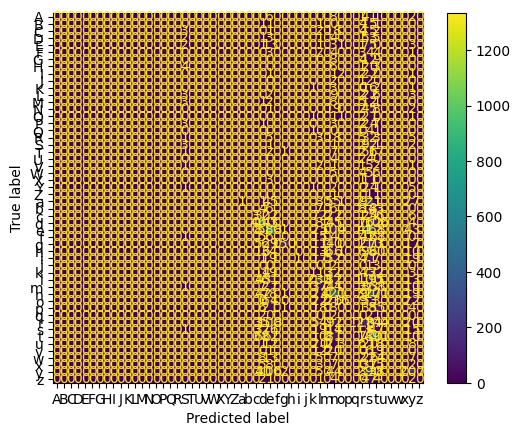

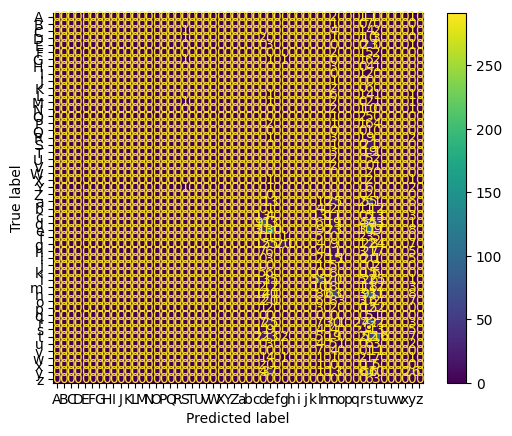

In [212]:
X = df_subset.embedding.tolist()
y = df_subset.text.str[-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=42, loss='log_loss', alpha=0.5)
clf.fit(X_train, y_train)

evaluate(X_train, y_train, clf, 'train')
evaluate(X_test, y_test, clf, 'test')

In [293]:

# from torch 

# for i in range(pos_embed.shape[0]):
    # print(pos_embed[i].norm())
    # plt.imshow(pos_embed[i].detach().cpu().numpy())
    # plt.show()

In [297]:
mags.shape

torch.Size([16])

0.8252968788146973


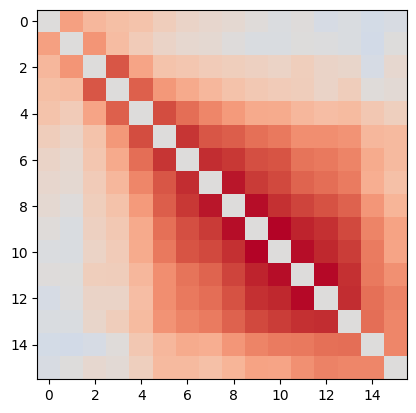

In [65]:
import matplotlib.pyplot as plt
import numpy as np

pos_embed = model.embedding_layer.subtoken_embedding.positional_embedding

dot_prods = torch.einsum('aij,bij->ab', pos_embed, pos_embed)
mags = torch.einsum('aij,aij->a', pos_embed, pos_embed).sqrt()
cosine = dot_prods / (mags.unsqueeze(-1) * mags.unsqueeze(-2))
cosine.fill_diagonal_(0.0)
M = cosine.abs().max().item()

print(M)
plt.imshow(cosine.detach().cpu().numpy(), vmin=-M, vmax=M, cmap='coolwarm')

In [66]:
from matplotlib import pyplot
import plotly.express as px
# pyplot.rcParams['figure.dpi'] = 600
# pyplot.rcParams['savefig.dpi'] = 600

byte_embedding = model.embedding_layer.subtoken_embedding.byte_embedding.weight
dot_prods = torch.einsum('ai,bi->ab', byte_embedding, byte_embedding)
mags = torch.einsum('ai,ai->a', byte_embedding, byte_embedding)
cosine = dot_prods / (mags.unsqueeze(0) * mags.unsqueeze(1)).sqrt()
cosine.fill_diagonal_(0.0)
# plt.imshow(cosine.detach().cpu().numpy()[:100, :100])
# torch.nn.functional.cosine_similarity(byte_embedding, byte_embedding).shape
# heatmap = torch.einsum('ai,bi->ab', byte_embedding, byte_embedding).detach().cpu().numpy()
# np.fill_diagonal(heatmap, 0.0)
# plt.imshow(heatmap)
codepoints = list(map(chr, range(256)))
fig = px.imshow( 
    cosine.detach().cpu().numpy(), x=codepoints, y=codepoints, width=800, height=800)#, color_continuous_scale='RdBu_r', origin='lower')
fig.show()

In [264]:
# byte_embedding.shape\
# torch.einsum('ai,ai->a', byte_embedding, byte_embedding).shape
cosine.diag()

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [96]:
VOCAB_SIZE = 50257
all_tokens_raw_text = tokenizer.convert_ids_to_tokens(
    list(range(VOCAB_SIZE))
)
all_tokens_actual_text = [
    tokenizer.convert_tokens_to_string([all_tokens_raw_text[id_]])
    for id_ in range(VOCAB_SIZE)
]
token_id_to_text = all_tokens_actual_text

TOKEN_REPLACEMENTS = {
        15171: [220, 16733, 7992],
        20727: [220, 403, 18789],
        27473: [220, 46813, 20860],
        28719: [220, 6381, 1676, 16864, 1286],
        29760: [220, 29609, 420, 28018],
        29789: [220, 25413, 4625, 5646],
        30210: [220, 48317, 13739, 3118, 18143],
        30213: [220, 22615, 2514, 27881, 10049],
        30982: [220, 6381, 1676, 16864, 378],
        32799: [220, 22769, 1634],
        34400: [220, 1783],
        36174: [220, 29531, 34832, 35992],
        36573: [220, 24588, 19541],
        36658: [220, 4770, 28],
        37389: [220, 12100, 12100],
        40586: [220, 38986, 282, 1023],
        40800: [220, 9979, 2738, 453],
        40887: [220, 70, 459, 305, 36387],
        42045: [220, 298, 7537, 72, 16607],
        43453: [220, 46933, 42202],
        43649: [220, 521, 396, 41726],
        44436: [220, 298, 10406, 1834, 1056],
        44713: [220, 4181],
        45545: [220, 26503, 44686, 42983],
        46674: [220, 24588, 27781],
        47757: [220, 259, 785, 3866, 5135, 856],
        48667: [220, 31709, 20860],
        16529: [220, 1783, 1783, 1783, 1783],
        20368: [220, 1783, 1783],
        38093: [220, 4770, 4770, 4770, 4770, 28],
        41436: [220, 35937, 35937],
        41906: [220, 8412, 8412],
        46111: [220, 4770, 4770, 28],
        30899: [21018, 30898],
        39177: [7449, 39142],
        39753: [39752, 10493],
        39755: [39714, 39655],
        39756: [24807, 31208],
        39757: [17620, 29841],
        40242: [39693, 40241],
        41380: [21353, 41215],
        30906: [30905, 21018, 30898],
        31576: [22615, 31573],
        3880: [1783, 1783],
        8864: [4181, 4181],
        10052: [4770, 4770],
        10097: [1783, 1783, 1783, 1783],
        10221: [4841, 4841],
        14950: [8184, 8184],
        17174: [8412, 8412],
        19351: [35937, 35937],
        22369: [10541, 10541],
        23193: [4181, 4181, 4181, 4181],
        14827: [9364, 9364],
        23090: [9364, 9364, 9364, 9364],
        23926: [4770, 4770, 4770, 4770],
        27006: [15243, 15243],
        27193: [4841, 4841, 4841, 4841],
        27754: [2109, 2109, 2109],
        49129: [16317, 16317, 16317],
        28542: [16068, 16068],
        29113: [14468, 14468],
        29146: [15864, 15864],
        30542: [8184, 8184, 8184, 8184],
        32941: [2602, 2602, 2602],
        49527: [20503, 20503],
        49704: [27246, 27246],
        35496: [9364, 9364, 9364, 9364, 9364, 9364, 9364, 9364],
        43801: [26171, 26171, 26171, 26171],
        47232: [1783, 1783, 1783],
        39172: [17811, 17811],
    }
EOT_ID = 50256
MAX_BYTES_PER_TOKEN = 16
FORBIDDEN_TOKENS = [45706]

def simplify(token_ids):
    tokens_with_replacement = []
    for t in token_ids:
        if t in FORBIDDEN_TOKENS:
            raise ValueError(
                "Token cannot be in FORBIDDEN_TOKENS"
            )  # TODO: somehow the forbidden tokens still show up :/ debug that
        elif t in TOKEN_REPLACEMENTS:
            tokens_with_replacement.extend(TOKEN_REPLACEMENTS[t])
        else:
            tokens_with_replacement.append(t)
    return tokens_with_replacement

def tokenize(text):
    input_ids = simplify(tokenizer(text)['input_ids'])
    input_bytes = []
    print(input_ids)
    for token in input_ids:
        print(token)
        if token != EOT_ID:
            bytes_ = list(token_id_to_text[token].encode("utf-8"))
            assert len(bytes_) <= MAX_BYTES_PER_TOKEN
            input_bytes.append(
                bytes_ + [-1] * (MAX_BYTES_PER_TOKEN - len(bytes_))
            )
        else:
            input_bytes.append([-1] * MAX_BYTES_PER_TOKEN)
        print(input_bytes)
        
    return input_ids, input_bytes
encoded = tokenize(
    "1 + 1 = 2\n2 + 3 = 5\n2 + 2 = ",
)
input_ids, input_bytes = encoded

out_tokens = model.forward(
    torch.tensor([input_ids], device='cuda'),
    torch.tensor([input_bytes], device='cuda')
).argmax(-1).flatten().detach().cpu().numpy().tolist()

# tokenizer.ids_to_
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(out_tokens))

[16, 1343, 352, 796, 362, 198, 17, 1343, 513, 796, 642, 198, 17, 1343, 362, 796, 220]
16
[[49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
1343
[[49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [32, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
352
[[49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [32, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [32, 49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
796
[[49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [32, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [32, 49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [32, 61, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
362
[[49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [32, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [32, 49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [32, 61, -1, -1, -1, -1, -1, -1

'. 1. 1.The. 1 = 1 +3 + 4 = 5 '

In [74]:
# encoded[0]
tokenizer.eot_id

AttributeError: 'GPT2TokenizerFast' object has no attribute 'eot_id'